In [ ]:
! pip install ta
! pip install yfinance

In [ ]:
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import yfinance as yf
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


**MA Crossover strategy:**

---



Long term / Slow
Short Term / Fast

Rules --> Variables --> Parameters

Rule --> Short Term Moving average Crosses a Long term Moving average

Variables --> Short MA / Long MA

Parameters --> 5 and 21


<Axes: xlabel='Date'>

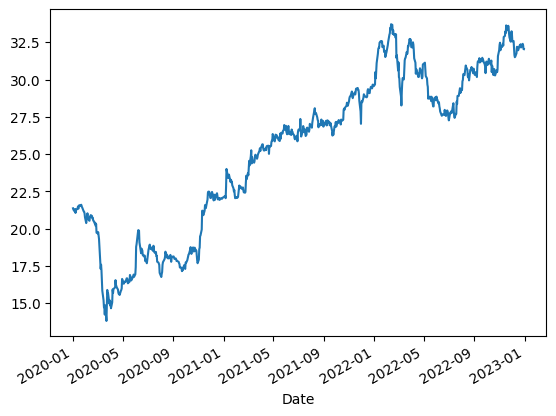

In [ ]:
#Define initial variables
stock_symbol = "D05.SI"
benchmark_symbol = "^STI"
start="2020-01-01"
end="2022-12-31"

#Get data and check
stock_data = yf.Ticker(stock_symbol)
hist_stock = stock_data.history(start = start, end = end)
hist_stock["Close"].plot()

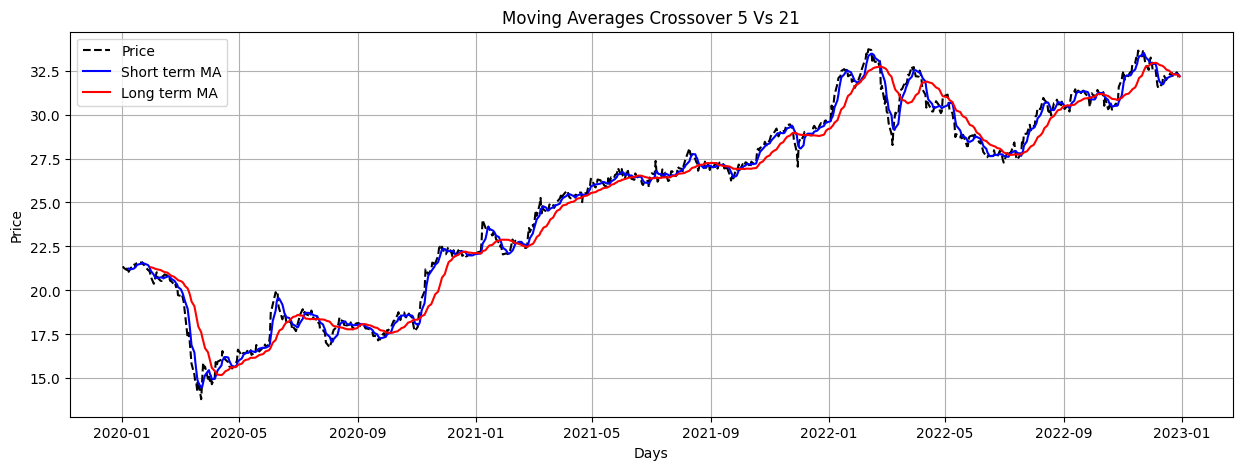

In [ ]:
# From previous notebook
# To plot a crossover of 50 Vs 200 days
ST_Window = 5
LT_Window = 21

# You can also make Moving averages by .rolling(window).mean(), but we are using library.
# Initialize SMAIndicator  and store the feature in a STMA and LTMA
indicator_1 = SMAIndicator(close = hist_stock["Close"], window= ST_Window, fillna= False)
STMA= indicator_1.sma_indicator()

indicator_2 = SMAIndicator(close = hist_stock["Close"], window= LT_Window, fillna= False)
LTMA = indicator_2.sma_indicator()

# Plot STMA and LTMA along with price
plt.figure(figsize=(15, 5))
plt.plot(hist_stock["Close"] ,color='black', label='Price', linestyle='dashed')
plt.plot(STMA, color='b', label='Short term MA')
plt.plot(LTMA, color='r', label='Long term MA')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Moving Averages Crossover {} Vs {}".format(ST_Window, LT_Window))
plt.legend()
plt.grid()
plt.show()

In [ ]:
'''
To backtest and add visualisations of the signals,
We will prepare a dataframe for storing all important variables.
This will help for further calc and visulaisation
'''

bt_data = pd.DataFrame()
bt_data["Close_Price"] = hist_stock["Close"]
bt_data["STMA"] = STMA
bt_data["LTMA"] = LTMA

# Note that you will lose n days of data due to MA
# Dropping all NA

bt_data = bt_data.dropna()
print(bt_data)


                           Close_Price       STMA       LTMA
Date                                                        
2020-01-31 00:00:00+08:00    20.763519  21.105624  21.317713
2020-02-03 00:00:00+08:00    20.378860  20.892833  21.270556
2020-02-04 00:00:00+08:00    20.583469  20.778254  21.237429
2020-02-05 00:00:00+08:00    20.828993  20.716052  21.221450
2020-02-06 00:00:00+08:00    21.033602  20.717689  21.207810
...                                ...        ...        ...
2022-12-23 00:00:00+08:00    32.153217  32.274123  32.292657
2022-12-27 00:00:00+08:00    32.398804  32.310017  32.272416
2022-12-28 00:00:00+08:00    32.304348  32.308127  32.261170
2022-12-29 00:00:00+08:00    32.049316  32.255231  32.215291
2022-12-30 00:00:00+08:00    32.039871  32.189111  32.158167

[735 rows x 3 columns]


In [ ]:
# More columns to Create Signals

# Long where  STMA is higher than LTMA
# Short where STMA is lower than LTMA

bt_data["Position"] = np.where(bt_data['STMA'] > bt_data['LTMA'], 1.0, -1.0)

#To create signal visuals, I am creating a signal column

bt_data["Signal"] = bt_data['Position'].diff()
bt_data

,Close_Price,STMA,LTMA,Position,Signal
Date,,,,,
2020-01-31 00:00:00+08:00,20.763519,21.105624,21.317713,-1.0,NaN
2020-02-03 00:00:00+08:00,20.378860,20.892833,21.270556,-1.0,0.0
2020-02-04 00:00:00+08:00,20.583469,20.778254,21.237429,-1.0,0.0
2020-02-05 00:00:00+08:00,20.828993,20.716052,21.221450,-1.0,0.0
2020-02-06 00:00:00+08:00,21.033602,20.717689,21.207810,-1.0,0.0
...,...,...,...,...,...
2022-12-23 00:00:00+08:00,32.153217,32.274123,32.292657,-1.0,0.0
2022-12-27 00:00:00+08:00,32.398804,32.310017,32.272416,1.0,2.0
2022-12-28 00:00:00+08:00,32.304348,32.308127,32.261170,1.0,0.0


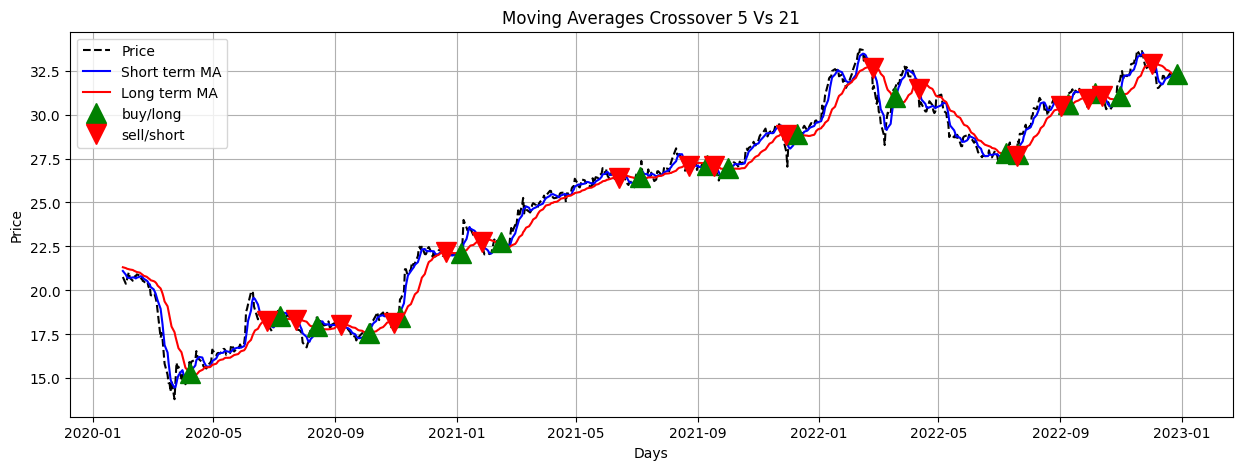

In [ ]:
# Visualising the strategy from the bt data

plt.figure(figsize=(15, 5))
plt.plot(bt_data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
plt.plot(bt_data["STMA"], color='b', label='Short term MA')
plt.plot(bt_data["LTMA"], color='r', label='Long term MA')

# plot ‘buy crossover’ signals.
# Because I have used +1 and -1,
# A buy signal will be created when the position was -1 and it turned to +1
# difference of +1 - -1 will give me 2

plt.plot(bt_data[bt_data['Signal'] == 2].index,
         bt_data['STMA'][bt_data['Signal'] == 2],
         '^', markersize = 15, color = 'g', label = 'buy/long')

# plot ‘sell crossover ’ signals
plt.plot(bt_data[bt_data['Signal'] == -2].index,
         bt_data['STMA'][bt_data['Signal'] == -2],
         'v', markersize = 15, color = 'r', label = 'sell/short')

plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Moving Averages Crossover {} Vs {}".format(ST_Window, LT_Window))
plt.legend()
plt.grid()
plt.show()



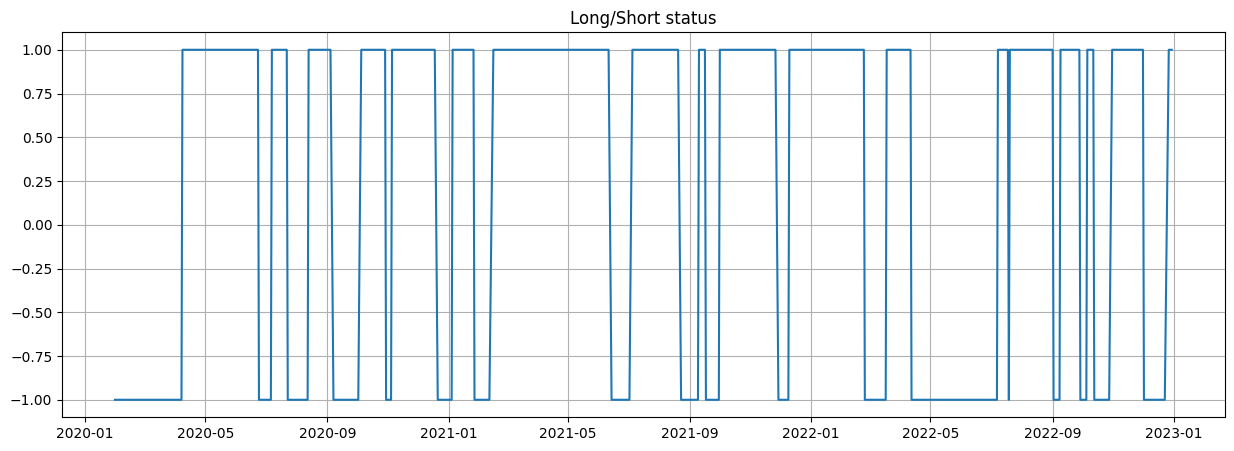

In [ ]:
# Lets look from the position view Long or Short
plt.figure(figsize=(15, 5))
plt.plot(bt_data["Position"])
plt.title("Long/Short status")
plt.grid()
plt.show()

Calculating the Performance of the Strategy

In [ ]:
# Daily Log Returns

# using shift gives up previous values
# Remember , These returns are the returns of the 'stock'.
# That is if you were invested all the time in the stock

# We are using log returns as they are additive. We cant simply add regular or aritmetic returns.
# Arithmetic /Regular returns are limited to  0 on the downside.
# adding all the daily log returns will give us the overall gross returns.
# Log returns are normally distributed and we can perform calculations.

bt_data['Stock_Returns'] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
print (bt_data)

                           Close_Price       STMA       LTMA  Position  \
Date                                                                     
2020-01-31 00:00:00+08:00    20.763519  21.105624  21.317713      -1.0   
2020-02-03 00:00:00+08:00    20.378860  20.892833  21.270556      -1.0   
2020-02-04 00:00:00+08:00    20.583469  20.778254  21.237429      -1.0   
2020-02-05 00:00:00+08:00    20.828993  20.716052  21.221450      -1.0   
2020-02-06 00:00:00+08:00    21.033602  20.717689  21.207810      -1.0   
...                                ...        ...        ...       ...   
2022-12-23 00:00:00+08:00    32.153217  32.274123  32.292657      -1.0   
2022-12-27 00:00:00+08:00    32.398804  32.310017  32.272416       1.0   
2022-12-28 00:00:00+08:00    32.304348  32.308127  32.261170       1.0   
2022-12-29 00:00:00+08:00    32.049316  32.255231  32.215291       1.0   
2022-12-30 00:00:00+08:00    32.039871  32.189111  32.158167       1.0   

                           Signal  St

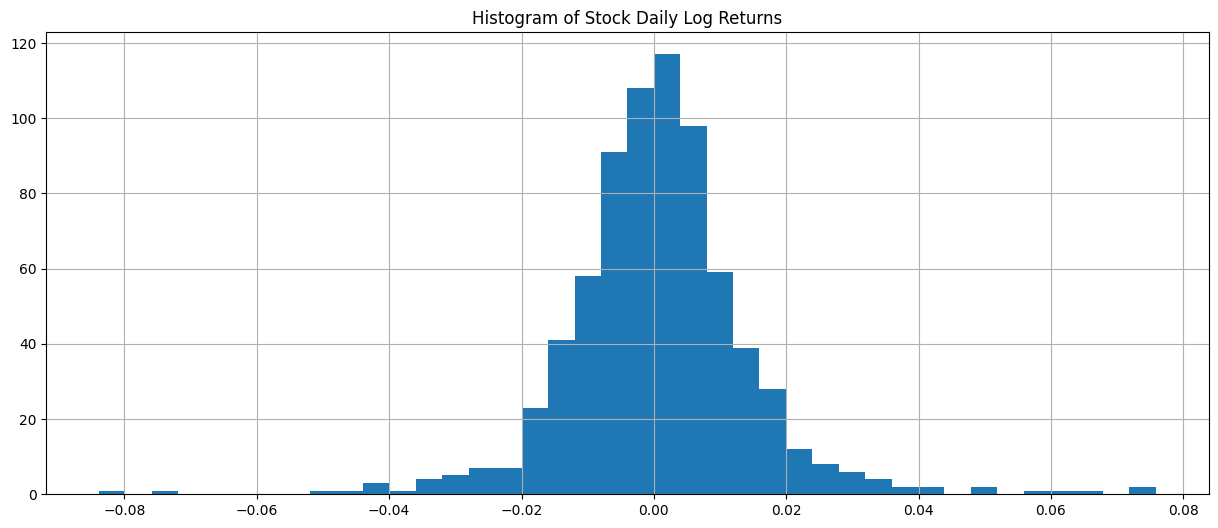

In [ ]:
# The histogram of returns
plt.figure(figsize=(15, 6))
plt.hist(bt_data["Stock_Returns"], bins = 40)
plt.title("Histogram of Stock Daily Log Returns")
plt.grid()
plt.show()

In [ ]:
# The stock gross returns can be calculated as
stock_returns = bt_data['Stock_Returns'].sum()
print (stock_returns)

#It can also be calculated as
srd = np.log(bt_data["Close_Price"][-1] / bt_data["Close_Price"][0])
print (srd)

#The values as same because log returns are additive in nature. Recall the Mu * 252 days concept from class

0.4337835362799933
0.43378353627999255


In [ ]:
# Next is to calculate the strategy returns.

# We can multiply todays returns with yesterdays position.
# This is because we  get the returns tomorrow based on todays position.

# The other way to look at it as consider you are taking position at market open
# becuse the STMA and LTMA will be available only after market closes.

#Storing the strategy returns in the data

bt_data["Strategy_Returns"] = bt_data["Stock_Returns"] * bt_data["Position"].shift(1)
print(bt_data)


                           Close_Price       STMA       LTMA  Position  \
Date                                                                     
2020-01-31 00:00:00+08:00    20.763519  21.105624  21.317713      -1.0   
2020-02-03 00:00:00+08:00    20.378860  20.892833  21.270556      -1.0   
2020-02-04 00:00:00+08:00    20.583469  20.778254  21.237429      -1.0   
2020-02-05 00:00:00+08:00    20.828993  20.716052  21.221450      -1.0   
2020-02-06 00:00:00+08:00    21.033602  20.717689  21.207810      -1.0   
...                                ...        ...        ...       ...   
2022-12-23 00:00:00+08:00    32.153217  32.274123  32.292657      -1.0   
2022-12-27 00:00:00+08:00    32.398804  32.310017  32.272416       1.0   
2022-12-28 00:00:00+08:00    32.304348  32.308127  32.261170       1.0   
2022-12-29 00:00:00+08:00    32.049316  32.255231  32.215291       1.0   
2022-12-30 00:00:00+08:00    32.039871  32.189111  32.158167       1.0   

                           Signal  St

In [ ]:
# The strategy returns can be calculated as
strategy_returns = bt_data['Strategy_Returns'].sum()
print (strategy_returns)


0.5519660326801276


In [ ]:
# We can compare both the stock and the strategy together as well

bt_data[["Stock_Returns", "Strategy_Returns"]].sum()

Stock_Returns       0.433784
Strategy_Returns    0.551966
dtype: float64

In [ ]:
#Imp
# Since we have used the log returns, just converting back to regular returns or the gross performance

#Log_returns = Ln(1 + Regular_returns)
#Regular_returns = Exp(Log_returns) - 1

bt_data[["Stock_Returns", "Strategy_Returns"]].sum().apply(np.exp) - 1


Stock_Returns       0.543085
Strategy_Returns    0.736664
dtype: float64

<Axes: xlabel='Date'>

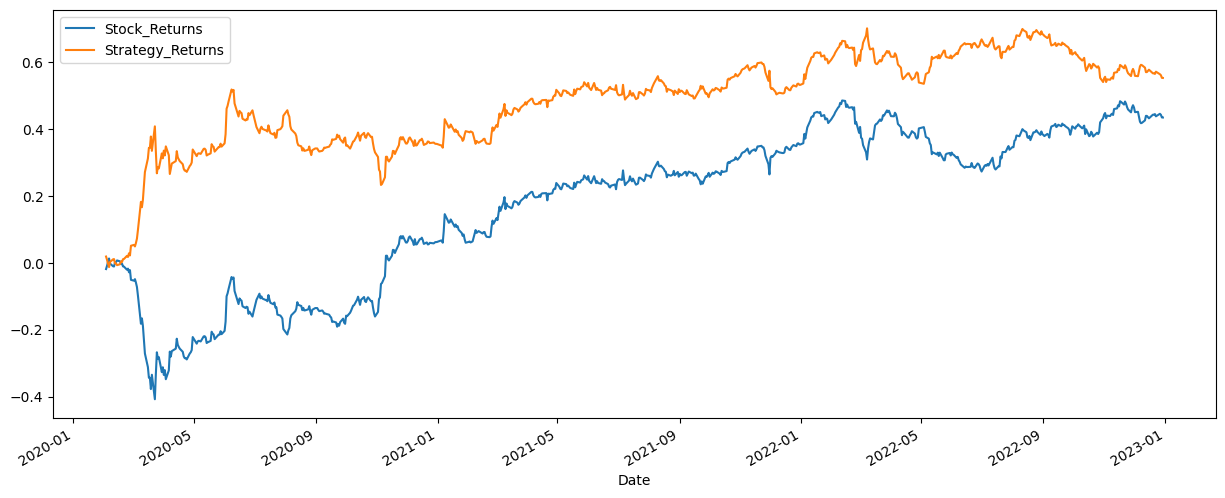

In [ ]:
# We can visulaise the performance over time with cumsum
# Comparing the stock returns and the strategy returns
# Cumsum Returns the cumulative sum of the elements along a given axis

bt_data[["Stock_Returns", "Strategy_Returns"]].cumsum().plot(figsize=(15,6))

<Axes: xlabel='Date'>

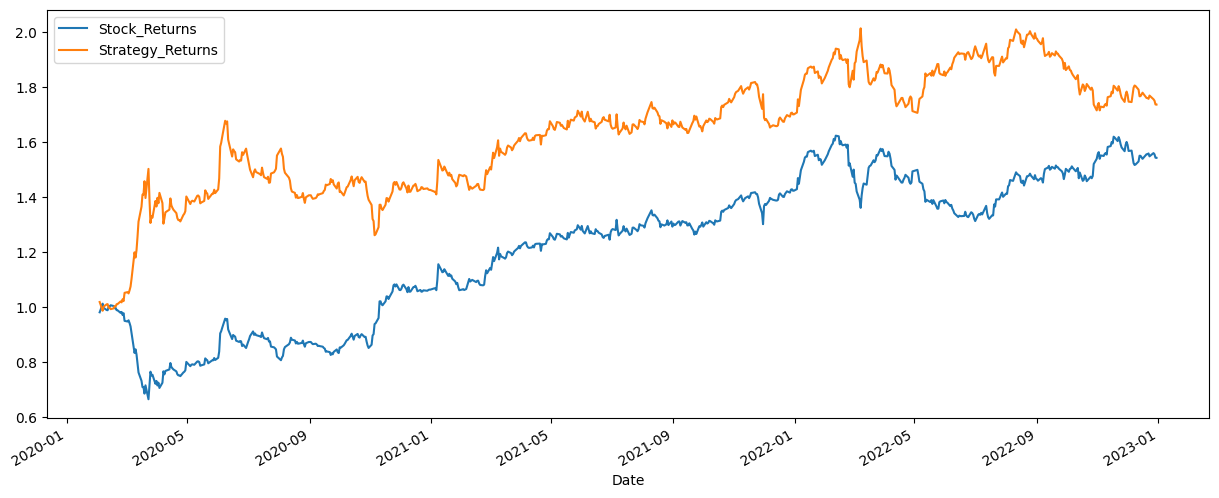

In [ ]:

# using exp will provide returns over 1

bt_data[["Stock_Returns", "Strategy_Returns"]].cumsum().apply(np.exp).plot(figsize=(15,6))


In [ ]:
'''
Now since we have returns of both the Stock and the Strategy, We can calculate the risk return performance metrics

1.Annualised returns
2.Annualised Risk or standard deviation
3.Sharpe Ratio

'''

# 1.  Annual Mean Returns or Expected returns
daily_ret = bt_data[["Stock_Returns", "Strategy_Returns"]].mean()
annual_ret =  daily_ret * 252
#print( 'Annual log returns are: \n', annual_ret) # Note that these are the log returns

# Convert back to regular returns
# Due to the statistical challenges, we cannot perform calculations on gross returns,
# Hence, we do that in log returns, and then convert back to regular

annual_regular_ret = np.exp(annual_ret)-1
print('Annual regular returns are: \n',annual_regular_ret)

#2. Annual Standard deviation
daily_std = bt_data[["Stock_Returns", "Strategy_Returns"]].std()
annual_std =  daily_std * (252 **0.5)
#print('Annual log std is: \n', annual_std) # Note that these are the log returns

#Convert to regular
daily_regular_std = (np.exp(bt_data[["Stock_Returns", "Strategy_Returns"]])-1).std()
annual_regular_std =  daily_regular_std * (252 **0.5)
print('Annual regular std is: \n', annual_regular_std) # Note that these are the log returns

#3. Sharpe Ratio
# Since we have already calculated the annual returns and risk we can use them

sr = annual_regular_ret/ annual_regular_std
print("The Sharpe Ratio is : \n ", sr)



Annual regular returns are: 
 Stock_Returns       0.160590
Strategy_Returns    0.208649
dtype: float64
Annual regular std is: 
 Stock_Returns       0.225028
Strategy_Returns    0.225171
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns       0.713644
Strategy_Returns    0.926624
dtype: float64


<Axes: xlabel='Date'>

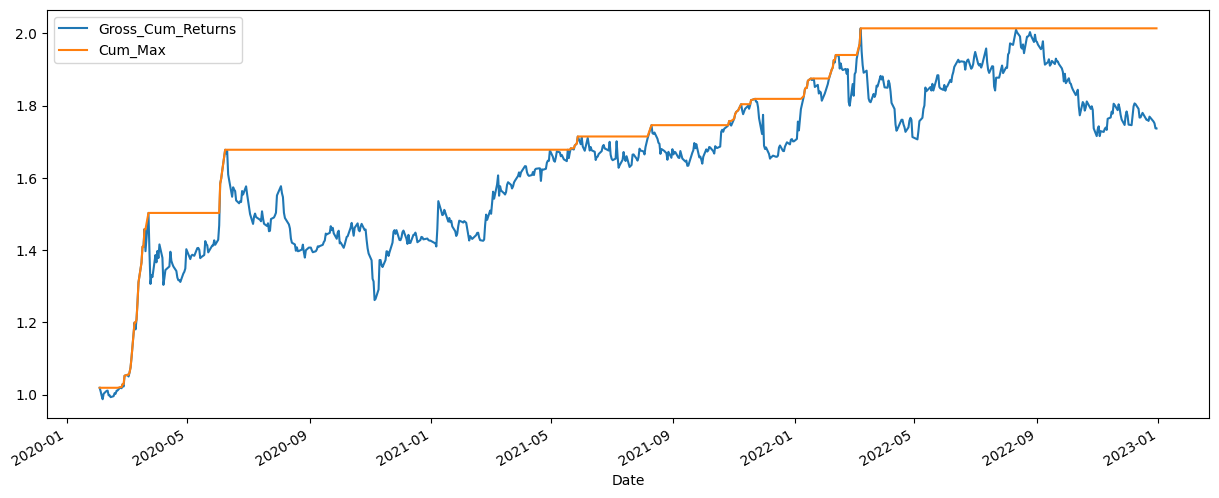

In [ ]:
# Lets calculate the drawdown of the strategy
# We will use pythons cummax method
# It Returns the cumulative maximum over a DataFrame or Series axis.

bt_data["Gross_Cum_Returns"] = bt_data["Strategy_Returns"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time

bt_data["Cum_Max"] = bt_data["Gross_Cum_Returns"].cummax()
bt_data[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize =(15,6))

In [ ]:
drawdown = bt_data["Cum_Max"] - bt_data["Gross_Cum_Returns"] # it gives the difference between orange and blue

bt_data["drawdown"] = drawdown

# The maximum difference is refered as "Drawdown"

bt_data["drawdown"].max()


0.41615455003468105

In [ ]:
# Although we know the max drawdown, we dont know how long it happened.
# Lets calculate tha max drawdown period
# The idea is to store all the points where the blue and orange meet (i.e. gross vs maximum)
# and then calculate the difference between these points. The highest difference is the longest drawdown period.

zero_periods = drawdown[drawdown == 0]

zero_periods

Date
2020-02-03 00:00:00+08:00    0.0
2020-02-24 00:00:00+08:00    0.0
2020-02-26 00:00:00+08:00    0.0
2020-02-28 00:00:00+08:00    0.0
2020-03-02 00:00:00+08:00    0.0
2020-03-04 00:00:00+08:00    0.0
2020-03-05 00:00:00+08:00    0.0
2020-03-06 00:00:00+08:00    0.0
2020-03-09 00:00:00+08:00    0.0
2020-03-11 00:00:00+08:00    0.0
2020-03-12 00:00:00+08:00    0.0
2020-03-13 00:00:00+08:00    0.0
2020-03-16 00:00:00+08:00    0.0
2020-03-17 00:00:00+08:00    0.0
2020-03-18 00:00:00+08:00    0.0
2020-03-19 00:00:00+08:00    0.0
2020-03-23 00:00:00+08:00    0.0
2020-06-03 00:00:00+08:00    0.0
2020-06-04 00:00:00+08:00    0.0
2020-06-05 00:00:00+08:00    0.0
2020-06-08 00:00:00+08:00    0.0
2021-05-18 00:00:00+08:00    0.0
2021-05-21 00:00:00+08:00    0.0
2021-05-25 00:00:00+08:00    0.0
2021-05-27 00:00:00+08:00    0.0
2021-05-28 00:00:00+08:00    0.0
2021-08-10 00:00:00+08:00    0.0
2021-10-27 00:00:00+08:00    0.0
2021-11-01 00:00:00+08:00    0.0
2021-11-02 00:00:00+08:00    0.0
2021-

In [ ]:
# Taking the difference from the previous period
delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
delta_values

TimedeltaIndex([ '21 days',   '2 days',   '2 days',   '3 days',   '2 days',
                  '1 days',   '1 days',   '3 days',   '2 days',   '1 days',
                  '1 days',   '3 days',   '1 days',   '1 days',   '1 days',
                  '4 days',  '72 days',   '1 days',   '1 days',   '3 days',
                '344 days',   '3 days',   '4 days',   '2 days',   '1 days',
                 '74 days',  '78 days',   '5 days',   '1 days',   '1 days',
                  '2 days',   '3 days',  '10 days',   '1 days',   '3 days',
                 '49 days',   '1 days',   '1 days',   '2 days',   '3 days',
                 '21 days',   '1 days',   '1 days',   '2 days',  '24 days',
                  '1 days'],
               dtype='timedelta64[ns]', name='Date', freq=None)

In [ ]:
delta_values.max()

Timedelta('344 days 00:00:00')

This is to understand the logic of Vexctorised backtesting.
We can make functions for different calculations and make a strategy class.
By doing that, we can use the backtester for any instrument and any period by just pressing a run button.